Created on Sunday, April 12, 2020

@author: Himanshu Gupta and Jamie Voros

ASEN 5044 Statistical Estimation, Spring 2020 - Project report 1 

In [891]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sp
from scipy.integrate import odeint
from numpy.linalg import inv
import pdb
import scipy.io
from scipy.stats.distributions import chi2

In [892]:
#Initializations

x0 = np.array([10,0,np.pi/2,-60,0,-np.pi/2])
u = np.array([2, -np.pi/18, 12, np.pi/25])
v= np.zeros(5).reshape(5,1)
L = 0.5
num_time_steps = 1000
num_time_steps_nom = 1001
delta_t = 0.1
time_steps = np.linspace(0, num_time_steps*delta_t, num_time_steps)
time_steps_nom = np.linspace(0, num_time_steps_nom*delta_t, num_time_steps_nom)
Rtrue = np.array([
    [0.0225, 0, 0, 0, 0],
    [0, 64, 0, 0, 0],
    [0, 0, 0.04, 0, 0],
    [0, 0, 0, 36, 0],
    [0, 0, 0, 0, 36]
                ])



#cholesky_decomposition_Qtrue = np.linalg.cholesky(Qtrue)
#cholesky_decomposition_Rtrue = np.linalg.cholesky(Rtrue)

print(np.linalg.cholesky(Qtrue))


[[0.03162278 0.         0.         0.         0.         0.        ]
 [0.         0.03162278 0.         0.         0.         0.        ]
 [0.         0.         0.03162278 0.         0.         0.        ]
 [0.         0.         0.         0.03162278 0.         0.        ]
 [0.         0.         0.         0.         0.03162278 0.        ]
 [0.         0.         0.         0.         0.         0.03162278]]


In [1347]:
#Generate Nominal trajectory with no noise
def model_nonoise(x, t, u, L):
    e_g = x[0]
    n_g = x[1]
    theta_g = x[2]
    e_a = x[3]
    n_a = x[4]
    theta_a = x[5]
    v_g = u[0]
    phi_g = u[1]
    v_a = u[2]
    w_a = u[3] 
    dxdt = [0]*6
    dxdt[0] = v_g*np.cos(theta_g)
    dxdt[1] = v_g*np.sin(theta_g)
    dxdt[2] = (v_g/L)*np.tan(phi_g)
    dxdt[3] = v_a*np.cos(theta_a)
    dxdt[4] = v_a*np.sin(theta_a)
    dxdt[5] = w_a
    return dxdt
#Generate True data with noise

def model(x, t, u, noise, L):
    e_g = x[0]
    n_g = x[1]
    theta_g = x[2]
    e_a = x[3]
    n_a = x[4]
    theta_a = x[5]
    v_g = u[0]
    phi_g = u[1]
    v_a = u[2]
    w_a = u[3] 
    dxdt = [0]*6
    dxdt[0] = v_g*np.cos(theta_g) + noise[0][0]
    dxdt[1] = v_g*np.sin(theta_g) + noise[1][0]
    dxdt[2] = (v_g/L)*np.tan(phi_g) + noise[2][0]
    dxdt[3] = v_a*np.cos(theta_a) + noise[3][0]
    dxdt[4] = v_a*np.sin(theta_a) + noise[4][0]
    dxdt[5] = w_a + noise[5][0]
    return dxdt

def calculate_exact_yt(x,v):
    temptop = (x[4]-x[1])
    tempbot = (x[3]-x[0])
    y1 = np.arctan2(temptop,tempbot) - (x[2])
    y1 = wrap_in_negative_pi_to_pi(y1)
    y2 = ( (x[0]-x[3])**2 + (x[1]-x[4])**2 ) ** 0.5
    y3 = np.arctan2(-temptop,-tempbot) - (x[5])
    y3 = wrap_in_negative_pi_to_pi(y3)
    y4 = x[3]
    y5 = x[4]
    
    yt = np.array([
                [y1],
                [y2],
                [y3],
                [y4],
                [y5]
                ])
    yt = yt + v
    return yt

def get_sample_noise(S):
    n = len(S)
    std_normal_covar_matrix = np.identity(n)
    std_normal_mean_matrix = np.zeros(n)
    sampled_noise_with_covar_I = np.random.multivariate_normal(std_normal_mean_matrix, std_normal_covar_matrix).reshape(n,1)
    sampled_noise_with_covar_Q = np.dot(S,sampled_noise_with_covar_I)
    return sampled_noise_with_covar_Q

def wrap_in_negative_pi_to_pi(theta):
    wrapped_angle = (theta + np.pi) % (2 * np.pi) - np.pi
    return wrapped_angle

def get_Xtrue(x0,time_steps,cholesky_decomposition_Qtrue,L):
    Xtrue = [x0]
    n = len(x0)
    for i in range(1,len(time_steps)):
        w = get_sample_noise(cholesky_decomposition_Qtrue)
        xk = Xtrue[-1]
        xk_plus1 = odeint(model, xk.reshape(n,), np.linspace(0, 0.1, 2), args = (u,w,L))
        xk_plus1 = xk_plus1[-1]
        xk_plus1[2] = wrap_in_negative_pi_to_pi(xk_plus1[2])
        xk_plus1[5] = wrap_in_negative_pi_to_pi(xk_plus1[5])
        xk_plus1 = xk_plus1.reshape(n,1)
        Xtrue.append(xk_plus1)    
    return Xtrue

def get_Ytrue(Xtrue,cholesky_decomposition_Rtrue):
    Ytrue = []
    n = len(Xtrue[0])
    for i in range(0,len(Xtrue)):
        v = get_sample_noise(cholesky_decomposition_Rtrue)
        yk = calculate_exact_yt(Xtrue[i].reshape(n,),v)
        yk[0] = wrap_in_negative_pi_to_pi(yk[0])
        yk[2] = wrap_in_negative_pi_to_pi(yk[2])
        Ytrue.append(yk)    
    return Ytrue

#observed_state_trajectory = get_Xtrue(x0,time_steps,cholesky_decomposition_Qtrue,L)
#observed_state_measurements = get_Ytrue(observed_state_trajectory,cholesky_decomposition_Rtrue)

## these are our nominal state trajectories and measurements with no process noise and no sensor noise.

## we use this to deteremine an output for our LKF
nom_state_trajectory = odeint(model_nonoise, x0, time_steps_nom, args = (u,L))
for i in range(0,len(nom_state_trajectory)):
    theta_g = nom_state_trajectory[i][2]
    theta_g = (theta_g + np.pi) % (2 * np.pi) - np.pi
    nom_state_trajectory[i][2] = theta_g
    theta_a = nom_state_trajectory[i][5]
    theta_a = (theta_a + np.pi) % (2 * np.pi) - np.pi
    nom_state_trajectory[i][5] = theta_a
    
nom_state_measurements = []
for i in range(0,len(nom_state_trajectory)):
    nom_state_measurements.append(calculate_exact_yt(nom_state_trajectory[i],v))

In [1348]:
def get_CT_Jacobians(x,u):
    
    A = np.array([
            [0, 0, -u[0]*np.sin(x[2]), 0, 0, 0],
            [0, 0, u[0]*np.cos(x[2]), 0, 0, 0],
            [0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, -u[2]*np.sin(x[5])],
            [0, 0, 0, 0, 0, u[2]*np.cos(x[5])],
            [0, 0, 0, 0, 0, 0]])

    
    B = np.array([
            [np.cos(x[2]), 0, 0, 0],
            [np.sin(x[2]), 0, 0, 0],
            [np.tan(u[1])/L, u[0]/(L*(np.cos(u[1])**2)), 0, 0],
            [0, 0, np.cos(x[5]), 0],
            [0, 0, np.sin(x[5]), 0],
            [0, 0, 0, 1]
            ])    
    
    Ga = np.eye(6)
    
    denominator_1 = 1 + ((x[4]-x[1])/(x[3]-x[0]))**2
    numerator_11 = (x[4]-x[1]) / ((x[3] - x[0])**2)
    C11 = numerator_11/denominator_1
    
    numerator_12 = -1/(x[3]-x[0])
    C12 = numerator_12/denominator_1
    
    C14 = -1*C11
    C15 = -1*C12
    
    denominator_2 = ( (x[0]-x[3])**2 + (x[1]-x[4])**2 ) ** 0.5
    C21 = (x[0]-x[3])/denominator_2
    C22 = (x[1]-x[4])/denominator_2
    C24 = -1*C21
    C25 = -1*C22
    
    C = np.array([
            [C11, C12, -1, C14, C15, 0],
            [C21, C22, 0, C24, C25, 0],
            [C11, C12, 0, C14, C15, -1],
            [0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 1, 0]
            ])

    D = 0
    
    return A, B, Ga, C, D

def get_DT_Jacobians(x,u,dt):
    
    A,B,Gamma,C,D = get_CT_Jacobians(x,u)
    
    F = np.eye(6) + dt*A
    G = dt*B
    Omega = delta_t*Gamma
    H = C
    M = D
    
    return F,G,Omega,H,M

In [1349]:
def k_matrix(P, H, R):
    PHt = np.matmul(P, np.transpose(H))
    HPHt = np.matmul(H, PHt)
    HPHt_R_inv = np.linalg.inv(HPHt + R)
    K = np.matmul(PHt, HPHt_R_inv)
    return K
    
    
def linear_kalman_filter(F, x, y, G, u, P, Q, H, R, Omega):
    x_predicted = np.dot(F,x) + np.dot(G,u)
    x_predicted[2] = wrap_in_negative_pi_to_pi(x_predicted[2])
    x_predicted[5] = wrap_in_negative_pi_to_pi(x_predicted[5])
    FP = np.matmul(F,P)
    P_predicted = np.matmul(FP,np.transpose(F)) + np.matmul(np.matmul(Omega,Q),np.transpose(Omega))
    K = k_matrix(P_predicted, H, R)
    error = y - np.dot(H,x_predicted)
    x = x_predicted + np.dot(K,error)
    x[2] = wrap_in_negative_pi_to_pi(x[2])
    x[5] = wrap_in_negative_pi_to_pi(x[5])
    P_update = np.identity(len(P)) - np.matmul(K,H)
    P = np.matmul(P_update,P_predicted)
    sk = np.dot(H,np.dot(P_predicted,H.transpose())) + R
    
    return x, P, sk

In [1350]:
def get_K_perturbations_LKF(initial_perturbation,nominal_state_trajectory,u,delta_t,K,P,R,Q, nominal_state_measurements,observed_state_measurements):
    
    delta_x0 = np.array(initial_perturbation).reshape(len(initial_perturbation),1) 
    delta_x_list = []
    delta_y_list = []
    P_list = []
    innovation_list = []
    delta_xk = delta_x0 
    delta_uk = np.zeros(4).reshape(4,1)
    Pk = P
    for k in range(0,K):
        delta_x_list.append(delta_xk)
        xk_nominal = nominal_state_trajectory[k]
        uk_nominal = u
        n = len(xk_nominal)
        noise = np.zeros(n).reshape(n,1)
        Fk,Gk,Omegak,Hk,Mk = get_DT_Jacobians(xk_nominal,uk_nominal,delta_t)
        Fk_plus1,Gk_plus1,Omegak_plus1,Hk,Mk_plus1 = get_DT_Jacobians(nominal_state_trajectory[k+1],uk_nominal,delta_t)
        delta_yk = observed_state_measurements[k] - nominal_state_measurements[k]
        delta_yk[0] = wrap_in_negative_pi_to_pi(delta_yk[0])
        delta_yk[2] = wrap_in_negative_pi_to_pi(delta_yk[2])
        delta_xk_plus1, Pk, Sk = linear_kalman_filter(Fk, delta_xk, delta_yk, Gk, delta_uk, Pk, Q, Hk, R, Omegak)
        delta_xk[2] = wrap_in_negative_pi_to_pi(delta_xk[2])
        delta_xk[5] = wrap_in_negative_pi_to_pi(delta_xk[5])
        delta_y_list.append(delta_yk)
        P_list.append(Pk)
        innovation_list.append(Sk)
        delta_xk = delta_xk_plus1
        
    return delta_x_list,delta_y_list, P_list, innovation_list


P = np.identity(6)
#initial_perturbation = 0.05*np.ones(len(x0))
initial_perturbation = np.array([0,0.1,0,0,0,0.01])
#delta_x_LKF_list, delta_y_LKF_list = get_K_perturbations_LKF(initial_perturbation, nominal_state_trajectory, u, delta_t, num_time_steps,P,Rtrue,Qtrue)

In [1351]:
def get_estimated_states_and_measurements(initial_perturbation, nominal_state_trajectory, u, delta_t, num_time_steps,P,Rtrue,Qtrue,nominal_state_measurements, observed_state_measurements):
    delta_x_LKF_list, delta_y_LKF_list, estimated_covariance_matrix_list, innovation_covariance_matrix_list = get_K_perturbations_LKF(initial_perturbation, nominal_state_trajectory, u, delta_t, num_time_steps,P,Rtrue,Qtrue,nominal_state_measurements, observed_state_measurements)
    estimated_state_list = []
    v=0
    for k in range(0,len(nominal_state_trajectory)-1):
        xk = nominal_state_trajectory[k].reshape(len(nominal_state_trajectory[k]),1) + delta_x_LKF_list[k]
        xk[2] = wrap_in_negative_pi_to_pi(xk[2])
        xk[5] = wrap_in_negative_pi_to_pi(xk[5])
        estimated_state_list.append(xk)
    
    estimated_measurement_list = []
    for k in range(0,len(estimated_state_list)):
        yk = calculate_exact_yt(estimated_state_list[k],v)
        yk = [i[0][0] for i in yk]
        estimated_measurement_list.append(yk)
        
    return estimated_state_list,estimated_covariance_matrix_list,estimated_measurement_list,innovation_covariance_matrix_list


In [1352]:
non_linear_trajectory_with_perturbed_x0 = odeint(model_nonoise, x0+initial_perturbation, time_steps, args = (u,L))
for i in range(0,len(non_linear_trajectory_with_perturbed_x0)):
    theta_g = non_linear_trajectory_with_perturbed_x0[i][2]
    theta_g = (theta_g + np.pi) % (2 * np.pi) - np.pi
    non_linear_trajectory_with_perturbed_x0[i][2] = theta_g
    theta_a = non_linear_trajectory_with_perturbed_x0[i][5]
    theta_a = (theta_a + np.pi) % (2 * np.pi) - np.pi
    non_linear_trajectory_with_perturbed_x0[i][5] = theta_a

non_linear_measurements_with_perturbed_x0 = []
for i in range(0,len(non_linear_trajectory_with_perturbed_x0)):
    non_linear_measurements_with_perturbed_x0.append(calculate_exact_yt(non_linear_trajectory_with_perturbed_x0[i],v))

In [1353]:
print(Qtrue)

[[0.001 0.    0.    0.    0.    0.   ]
 [0.    0.001 0.    0.    0.    0.   ]
 [0.    0.    0.01  0.    0.    0.   ]
 [0.    0.    0.    0.001 0.    0.   ]
 [0.    0.    0.    0.    0.001 0.   ]
 [0.    0.    0.    0.    0.    0.01 ]]


In [1550]:
#Tuning by changing Qfilter 
mat = scipy.io.loadmat('data.mat')
Qtrue = mat["Qtrue"]
Rtrue = mat["Rtrue"]

Q11 = 12
Q12 = 1
Q13 = 0
Q14 = 3
Q15 = 3
Q22 = 6
Q23 = 0
Q24 = 3
Q25 = 3
Q33 = 22
Q36 = 5
Q44 = 8
Q45 = 3
Q46 = 0
Q55 = 8
Q56 = 0
Q66 = 18

Qfilter = np.array([
        [Q11,    Q12,    Q13   , Q14   , Q15   , 0.   ],
        [Q12 ,    Q22,   Q23   , Q24   , Q25   , 0.   ],
        [Q13,    Q23,   Q33   , 0.   , 0.   , Q36   ],
        [Q14   , Q24   , 0.   , Q44    , Q45   , Q46   ],
        [Q15   , Q25   , 0.   , Q45     , Q55  , Q56   ],
        [0.   , 0.   , Q36   , Q46    , Q56  , Q66 ]
    ])

Qfilter = 0.0004*Qfilter
P = 20*Qfilter

In [1551]:
#NEES and NIS

def get_weighted_error_x_at_step_k(actual_x,estimated_x,Pk):
    ek = actual_x - estimated_x
    ek[2] = wrap_in_negative_pi_to_pi(ek[2])
    ek[5] = wrap_in_negative_pi_to_pi(ek[5])
    epsilon = np.dot(ek.transpose(),np.dot(np.linalg.inv(Pk),ek))
    return epsilon[0][0]

def get_epsilon_x_for_all_time_steps_in_one_simulation(actual_x_list, estimated_x_list, estimated_P_list):
    epsilon_x_list = []
    for k in range(0,len(actual_x_list)):
        epsilon_at_step_k = get_weighted_error_x_at_step_k(actual_x_list[k],estimated_x_list[k],estimated_P_list[k])
        epsilon_x_list.append(epsilon_at_step_k)
        
    return epsilon_x_list

def get_weighted_error_y_at_step_k(actual_x,estimated_x,Pk):
    ek = actual_x - estimated_x
    ek[0] = wrap_in_negative_pi_to_pi(ek[0])
    ek[2] = wrap_in_negative_pi_to_pi(ek[2])
    epsilon = np.dot(ek.transpose(),np.dot(np.linalg.inv(Pk),ek))
    return epsilon[0][0]

def get_epsilon_y_for_all_time_steps_in_one_simulation(actual_y_list, estimated_y_list, estimated_S_list):
    epsilon_y_list = []
    for k in range(0,len(actual_y_list)):
        epsilon_at_step_k = get_weighted_error_y_at_step_k(actual_y_list[k],estimated_y_list[k],estimated_S_list[k])
        epsilon_y_list.append(epsilon_at_step_k)
        
    return epsilon_y_list

def get_NEES_data_for_multiple_simulations(x0,P0,u,Qtrue,Rtrue,Qfilter,Rfilter,num_mc_simulations):
    NEES_data = np.zeros(shape=(num_mc_simulations,1000))
    NIS_data = np.zeros(shape=(num_mc_simulations,1000))
    cholesky_decomposition_Q = np.linalg.cholesky(Qtrue)
    cholesky_decomposition_R = np.linalg.cholesky(Rtrue)

    for i in range(0,num_mc_simulations):
        print("Performing simulation number " + str(i))
        Xtrue = get_Xtrue(x0,time_steps,cholesky_decomposition_Q,L)
        Ytrue = get_Ytrue(Xtrue,cholesky_decomposition_R)
        
        estimated_state_list,estimated_covariance_matrix_list,\
        estimated_measurement_list,innovation_covariance_matrix_list = \
        get_estimated_states_and_measurements(initial_perturbation, nom_state_trajectory, u, delta_t, \
                                          num_time_steps,P,Rfilter,Qfilter,nom_state_measurements,Ytrue)
        
        epsilon_x_for_all_time_steps_in_one_simulation = \
        get_epsilon_x_for_all_time_steps_in_one_simulation(Xtrue,estimated_state_list, estimated_covariance_matrix_list)
        
        
        epsilon_y_for_all_time_steps_in_one_simulation = get_epsilon_y_for_all_time_steps_in_one_simulation \
        (Ytrue,estimated_measurement_list, innovation_covariance_matrix_list)

        NIS_data[i] = np.array(epsilon_y_for_all_time_steps_in_one_simulation)
        NEES_data[i] = np.array(epsilon_x_for_all_time_steps_in_one_simulation)
        
    return NEES_data,NIS_data, estimated_state_list, estimated_measurement_list
num_mc_simulations = 10
NEES_data,NIS_data,linearized_DT_states_LKF, linearized_DT_measurements_LKF = get_NEES_data_for_multiple_simulations(x0,P,u,Qtrue,Rtrue,Qfilter,Rfilter,num_mc_simulations)

Performing simulation number 0
Performing simulation number 1
Performing simulation number 2
Performing simulation number 3
Performing simulation number 4
Performing simulation number 5
Performing simulation number 6
Performing simulation number 7
Performing simulation number 8
Performing simulation number 9


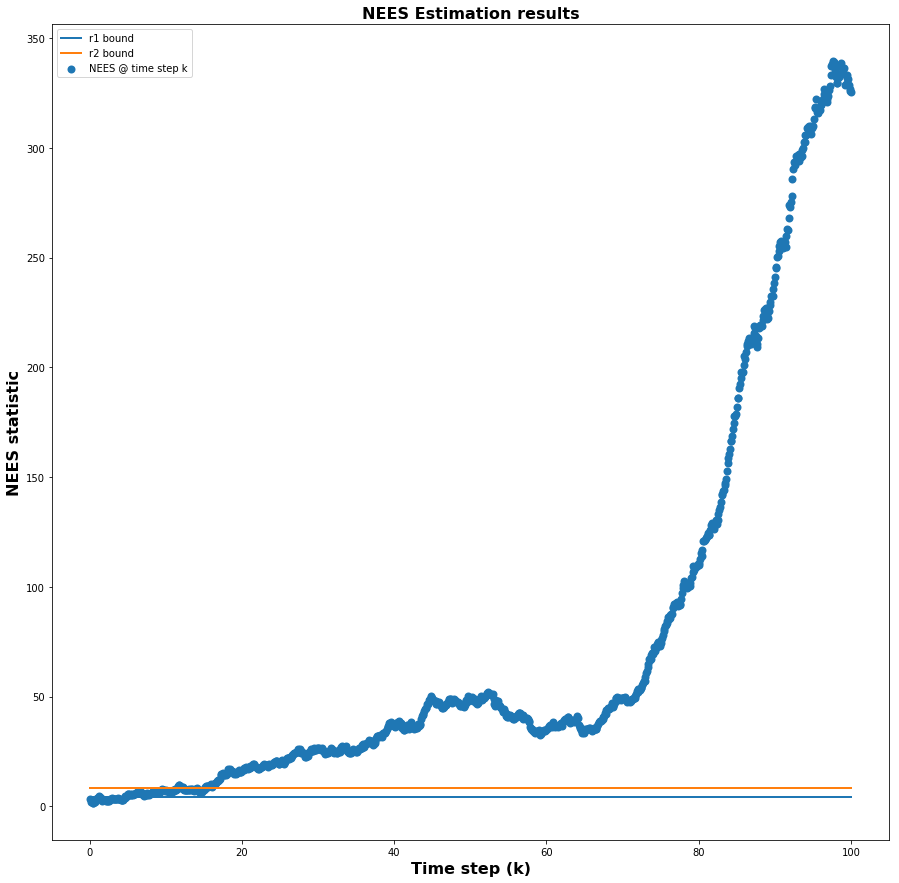

In [1552]:
skip = 1
NEES_mean_list = NEES_data.mean(axis=0)
N = num_mc_simulations
n = len(x0)
r1 = chi2.ppf(0.025, df=N*n)/N
r2 = chi2.ppf(0.975, df=N*n)/N

#plt.plot(time_steps,NEES_mean_list)
r1_bound = [r1]*len(time_steps)
r2_bound = [r2]*len(time_steps)
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("NEES statistic",fontsize=16, fontweight='bold')
plt.title("NEES Estimation results",fontsize=16, fontweight='bold')
plt.scatter(time_steps[skip:],NEES_mean_list[skip:],linewidth = 2,label = 'NEES @ time step k')
plt.plot(time_steps[skip:],r1_bound[skip:],linewidth = 2,label = 'r1 bound')
plt.plot(time_steps[skip:],r2_bound[skip:],linewidth = 2,label = 'r2 bound')
plt.legend()

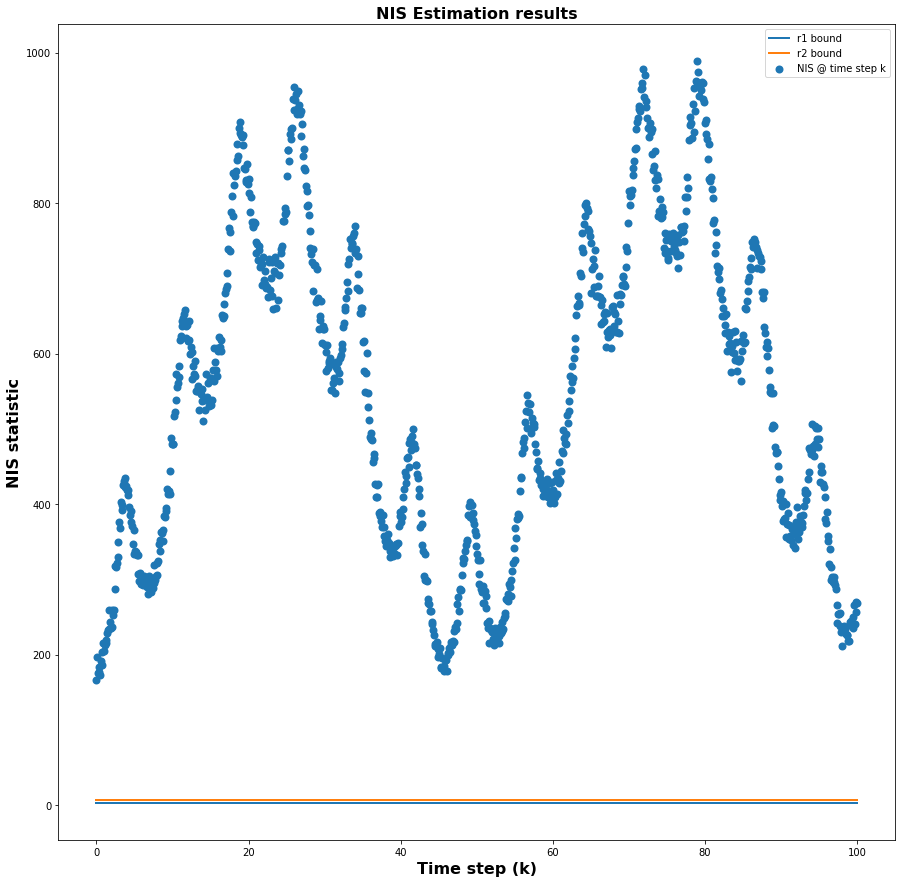

In [1553]:
NIS_mean_list = NIS_data.mean(axis=0)
N = num_mc_simulations
p = len(Rtrue)
r1 = chi2.ppf(0.025, df=N*p)/N
r2 = chi2.ppf(0.975, df=N*p)/N

#plt.plot(time_steps,NEES_mean_list)
r1_bound = [r1]*len(time_steps)
r2_bound = [r2]*len(time_steps)
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("NIS statistic",fontsize=16, fontweight='bold')
plt.title("NIS Estimation results",fontsize=16, fontweight='bold')
plt.scatter(time_steps,NIS_mean_list,linewidth = 2,label = 'NIS @ time step k')
plt.plot(time_steps,r1_bound,linewidth = 2,label = 'r1 bound')
plt.plot(time_steps,r2_bound,linewidth = 2,label = 'r2 bound')
plt.legend()

In [1554]:


cholesky_decomposition_Q = np.linalg.cholesky(Qtrue)
cholesky_decomposition_R = np.linalg.cholesky(Rtrue)
Xtrue = get_Xtrue(x0,time_steps,cholesky_decomposition_Q,L)
Ytrue = get_Ytrue(Xtrue,cholesky_decomposition_R)

estimated_state_list,estimated_covariance_matrix_list,\
        estimated_measurement_list,innovation_covariance_matrix_list = \
        get_estimated_states_and_measurements(initial_perturbation, nom_state_trajectory, u, delta_t, \
                                          num_time_steps,P,Rtrue,Qfilter,nom_state_measurements,Ytrue)

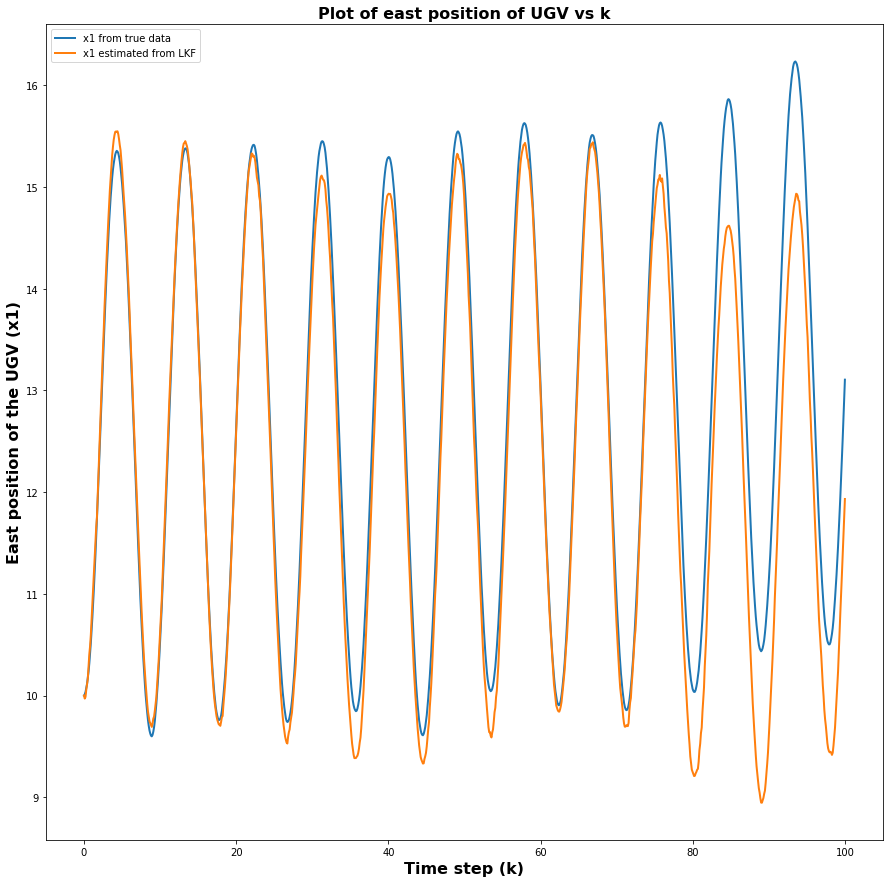

In [1555]:
#Plot x[1] or east position of UGV

true_x1 = []
estimated_x1 = []

for state in Xtrue:
    true_x1.append(state[0])
    
for state in estimated_state_list:
    estimated_x1.append(state[0][0])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("East position of the UGV (x1)",fontsize=16, fontweight='bold')
plt.title("Plot of east position of UGV vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,true_x1,linewidth = 2,label = 'x1 from true data')
plt.plot(time_steps,estimated_x1,linewidth = 2,label = 'x1 estimated from LKF')
plt.legend()



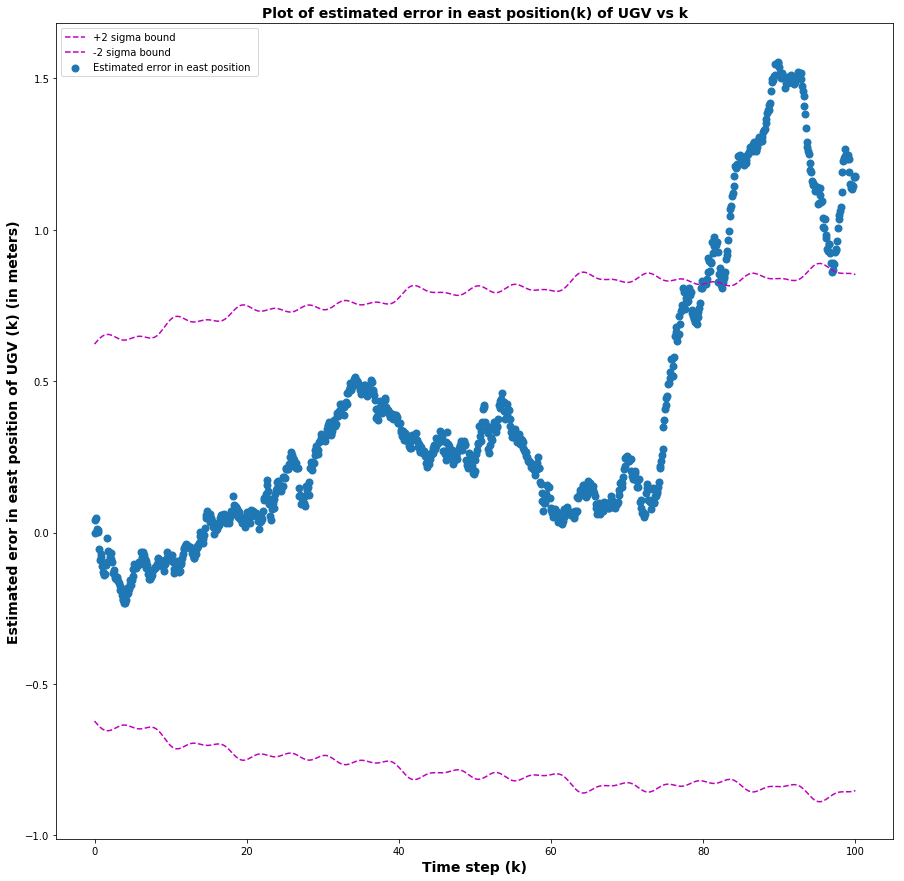

In [1556]:
#Error in East Position of UGV
estimated_state1_error_list = []
positive_two_sigma_state_element1_list = []
negative_two_sigma_state_element1_list = []

for i in range(0,len(estimated_state_list)):
    curr_estimate = estimated_x1[i]
    curr_variance = estimated_covariance_matrix_list[i][0][0]
    sigma = np.sqrt(curr_variance)
    bound = 2*sigma
    curr_error = true_x1[i] - curr_estimate
    estimated_state1_error_list.append(curr_error)
    positive_two_sigma_state_element1_list.append(bound)
    negative_two_sigma_state_element1_list.append(-bound)

plt.xlabel("Time step (k)",fontsize=14, fontweight='bold')
plt.ylabel("Estimated eror in east position of UGV (k) (in meters)",fontsize=14, fontweight='bold')
plt.title("Plot of estimated error in east position(k) of UGV vs k",fontsize=14, fontweight='bold')
plt.scatter(time_steps[skip_till:],estimated_state1_error_list[skip_till:],linewidth = 2,label = 'Estimated error in east position ')
plt.plot(time_steps[skip_till:],positive_two_sigma_state_element1_list[skip_till:],'--m',label = '+2 sigma bound')
plt.plot(time_steps[skip_till:],negative_two_sigma_state_element1_list[skip_till:],'--m',label = '-2 sigma bound')
plt.legend()

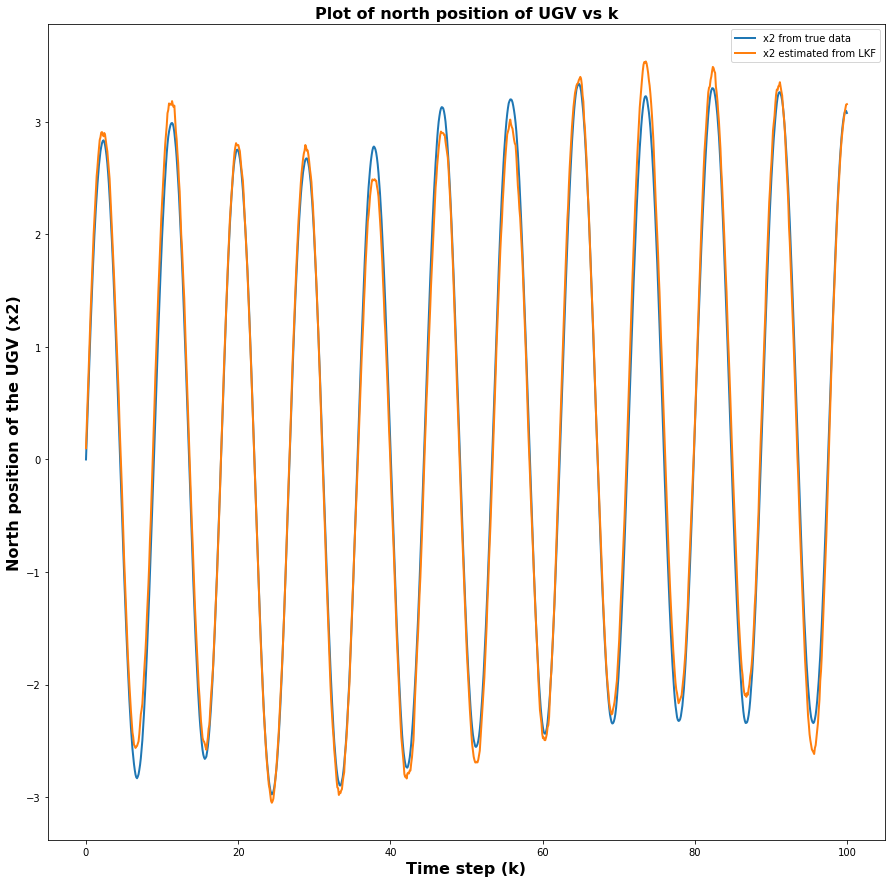

In [1520]:
#Plot x[2] or north position of UGV

true_x2 = []
estimated_x2 = []

for state in Xtrue:
    true_x2.append(state[1])
    
for state in estimated_state_list:
    estimated_x2.append(state[1][0])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("North position of the UGV (x2)",fontsize=16, fontweight='bold')
plt.title("Plot of north position of UGV vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,true_x2,linewidth = 2,label = 'x2 from true data')
plt.plot(time_steps,estimated_x2,linewidth = 2,label = 'x2 estimated from LKF')
plt.legend()



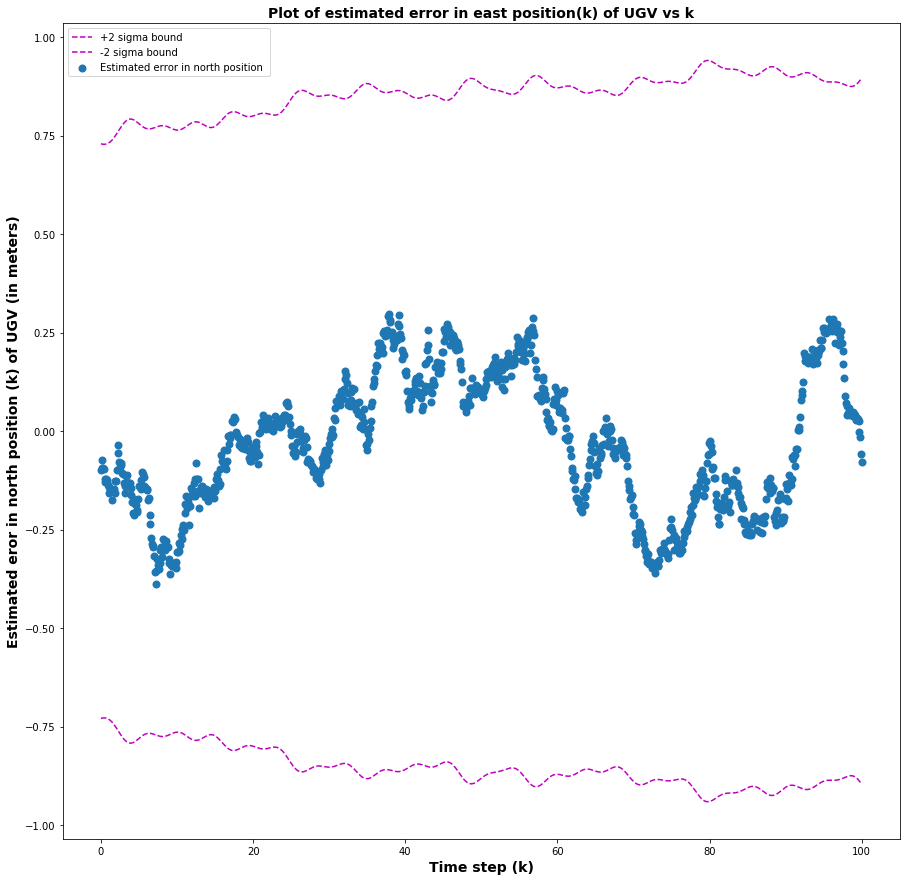

In [1521]:
#Error in North Position of UGV
estimated_state2_error_list = []
positive_two_sigma_state_element2_list = []
negative_two_sigma_state_element2_list = []

for i in range(0,len(estimated_state_list)):
    curr_estimate = estimated_x2[i]
    curr_variance = estimated_covariance_matrix_list[i][1][1]
    sigma = np.sqrt(curr_variance)
    bound = 2*sigma
    curr_error = true_x2[i] - curr_estimate
    estimated_state2_error_list.append(curr_error)
    positive_two_sigma_state_element2_list.append(bound)
    negative_two_sigma_state_element2_list.append(-bound)
    
plt.xlabel("Time step (k)",fontsize=14, fontweight='bold')
plt.ylabel("Estimated eror in north position (k) of UGV (in meters)",fontsize=14, fontweight='bold')
plt.title("Plot of estimated error in east position(k) of UGV vs k",fontsize=14, fontweight='bold')
plt.scatter(time_steps[skip_till:],estimated_state2_error_list[skip_till:],linewidth = 2,label = 'Estimated error in north position ')
plt.plot(time_steps[skip_till:],positive_two_sigma_state_element2_list[skip_till:],'--m',label = '+2 sigma bound')
plt.plot(time_steps[skip_till:],negative_two_sigma_state_element2_list[skip_till:],'--m',label = '-2 sigma bound')
plt.legend()

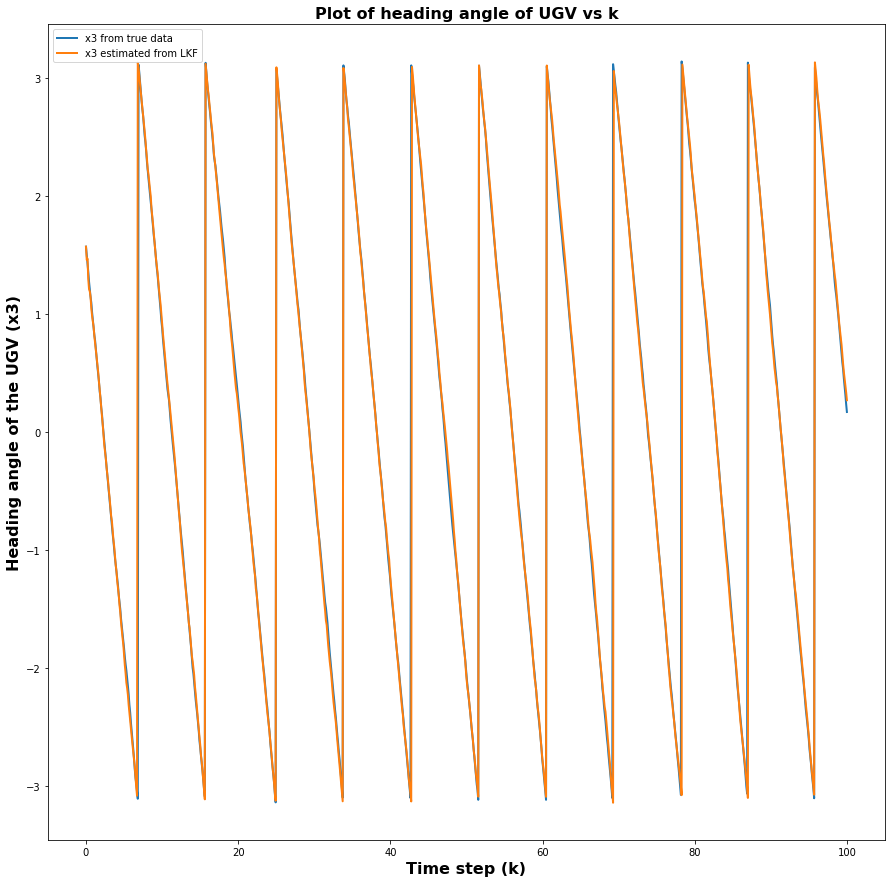

In [1495]:
#Plot x[3] or heading angle of UGV

true_x3 = []
estimated_x3 = []

for state in Xtrue:
    true_x3.append(state[2])
    
for state in estimated_state_list:
    estimated_x3.append(state[2][0])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("Heading angle of the UGV (x3)",fontsize=16, fontweight='bold')
plt.title("Plot of heading angle of UGV vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,true_x3,linewidth = 2,label = 'x3 from true data')
plt.plot(time_steps,estimated_x3,linewidth = 2,label = 'x3 estimated from LKF')
plt.legend()



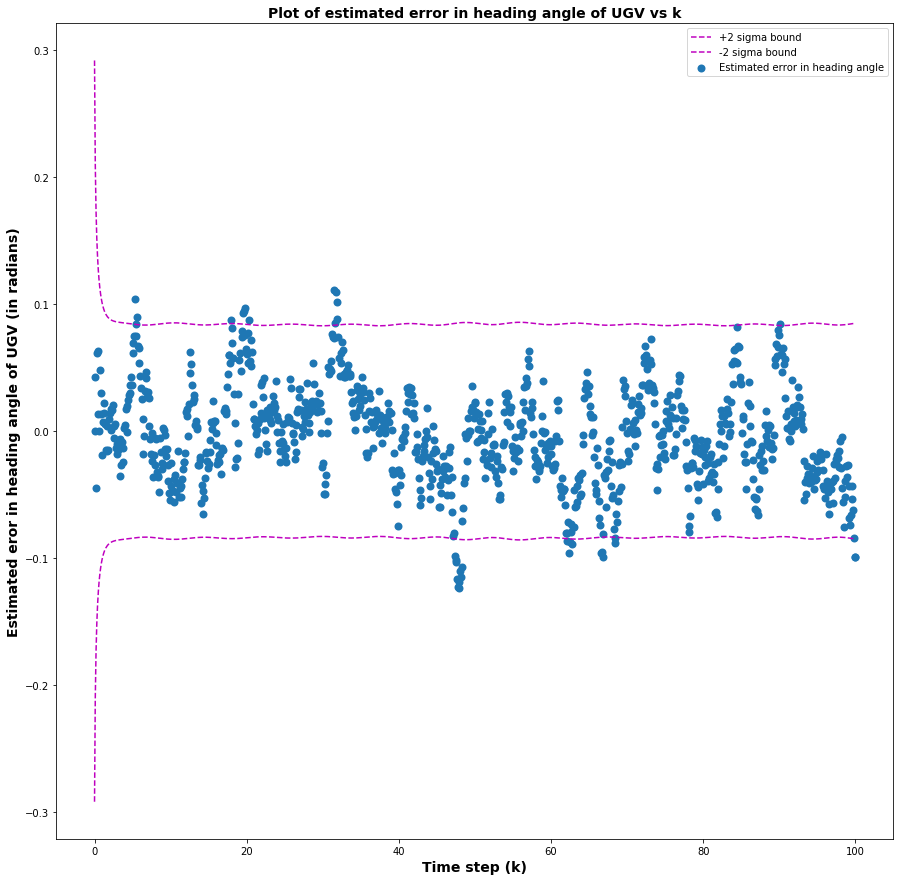

In [1496]:
#Error in heading angle of UGV
estimated_state3_error_list = []
positive_two_sigma_state_element3_list = []
negative_two_sigma_state_element3_list = []

for i in range(0,len(estimated_state_list)):
    curr_estimate = estimated_x3[i]
    curr_variance = estimated_covariance_matrix_list[i][2][2]
    sigma = np.sqrt(curr_variance)
    bound = 2*sigma
    curr_error = true_x3[i] - curr_estimate
    curr_error = wrap_in_negative_pi_to_pi(curr_error)
    estimated_state3_error_list.append(curr_error)
    positive_two_sigma_state_element3_list.append(bound)
    negative_two_sigma_state_element3_list.append(-bound)

plt.xlabel("Time step (k)",fontsize=14, fontweight='bold')
plt.ylabel("Estimated eror in heading angle of UGV (in radians)",fontsize=14, fontweight='bold')
plt.title("Plot of estimated error in heading angle of UGV vs k",fontsize=14, fontweight='bold')
plt.scatter(time_steps[skip_till:],estimated_state3_error_list[skip_till:],linewidth = 2,label = 'Estimated error in heading angle')
plt.plot(time_steps[skip_till:],positive_two_sigma_state_element3_list[skip_till:],'--m',label = '+2 sigma bound')
plt.plot(time_steps[skip_till:],negative_two_sigma_state_element3_list[skip_till:],'--m',label = '-2 sigma bound')
plt.legend()

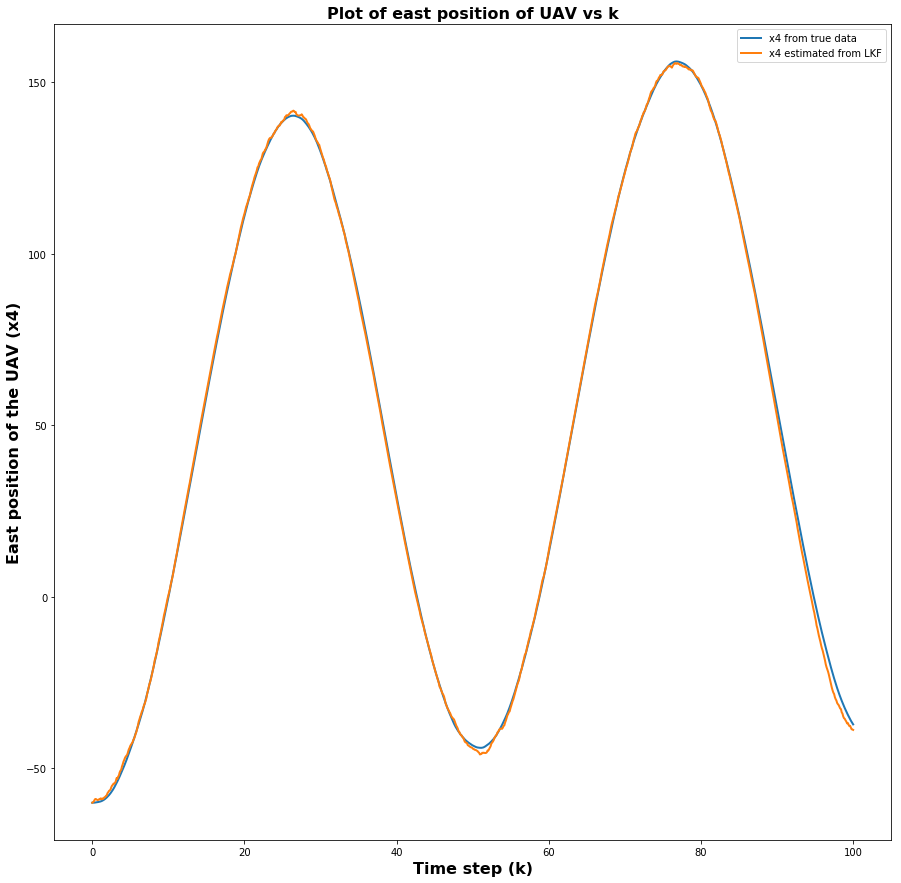

In [1497]:
#Plot x[4] or east position of UAV

true_x4 = []
estimated_x4 = []

for state in Xtrue:
    true_x4.append(state[3])
    
for state in estimated_state_list:
    estimated_x4.append(state[3][0])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("East position of the UAV (x4)",fontsize=16, fontweight='bold')
plt.title("Plot of east position of UAV vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,true_x4,linewidth = 2,label = 'x4 from true data')
plt.plot(time_steps,estimated_x4,linewidth = 2,label = 'x4 estimated from LKF')

plt.legend()



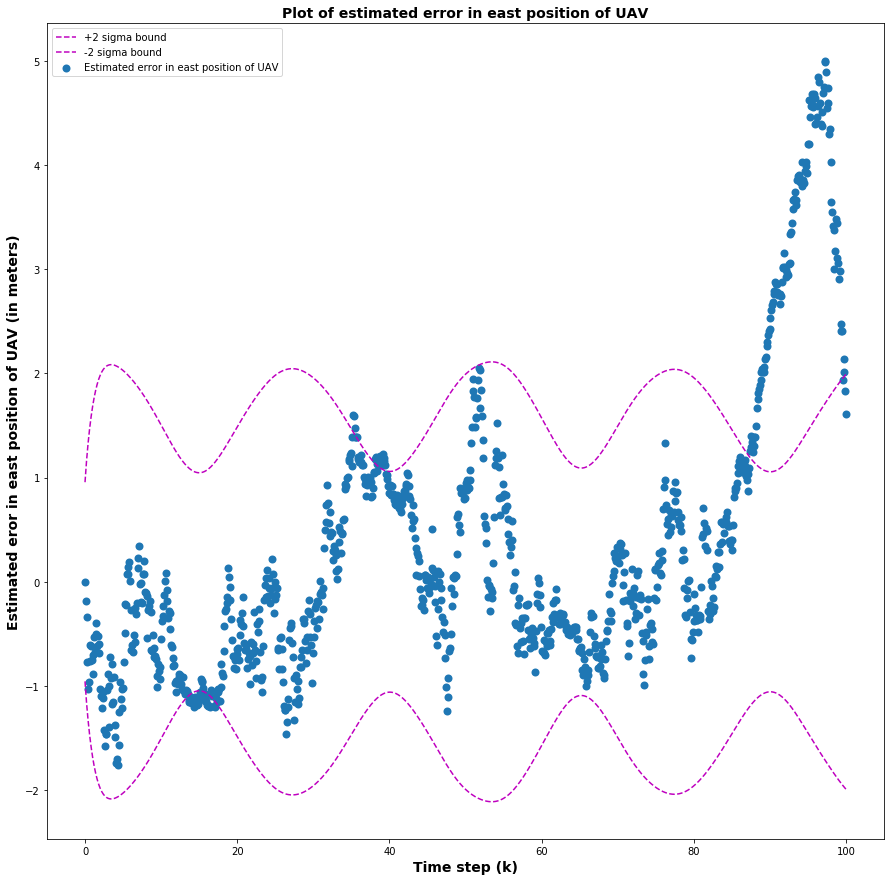

In [1498]:
#Error in east position of UAV
estimated_state4_error_list = []
positive_two_sigma_state_element4_list = []
negative_two_sigma_state_element4_list = []

for i in range(0,len(estimated_state_list)):
    curr_estimate = estimated_x4[i]
    curr_variance = estimated_covariance_matrix_list[i][3][3]
    sigma = np.sqrt(curr_variance)
    bound = 2*sigma
    curr_error = true_x4[i] - curr_estimate
    estimated_state4_error_list.append(curr_error)
    positive_two_sigma_state_element4_list.append(bound)
    negative_two_sigma_state_element4_list.append(-bound)
    
plt.xlabel("Time step (k)",fontsize=14, fontweight='bold')
plt.ylabel("Estimated eror in east position of UAV (in meters)",fontsize=14, fontweight='bold')
plt.title("Plot of estimated error in east position of UAV",fontsize=14, fontweight='bold')
plt.scatter(time_steps[skip_till:],estimated_state4_error_list[skip_till:],linewidth = 2,label = 'Estimated error in east position of UAV')
plt.plot(time_steps[skip_till:],positive_two_sigma_state_element4_list[skip_till:],'--m',label = '+2 sigma bound')
plt.plot(time_steps[skip_till:],negative_two_sigma_state_element4_list[skip_till:],'--m',label = '-2 sigma bound')
plt.legend()

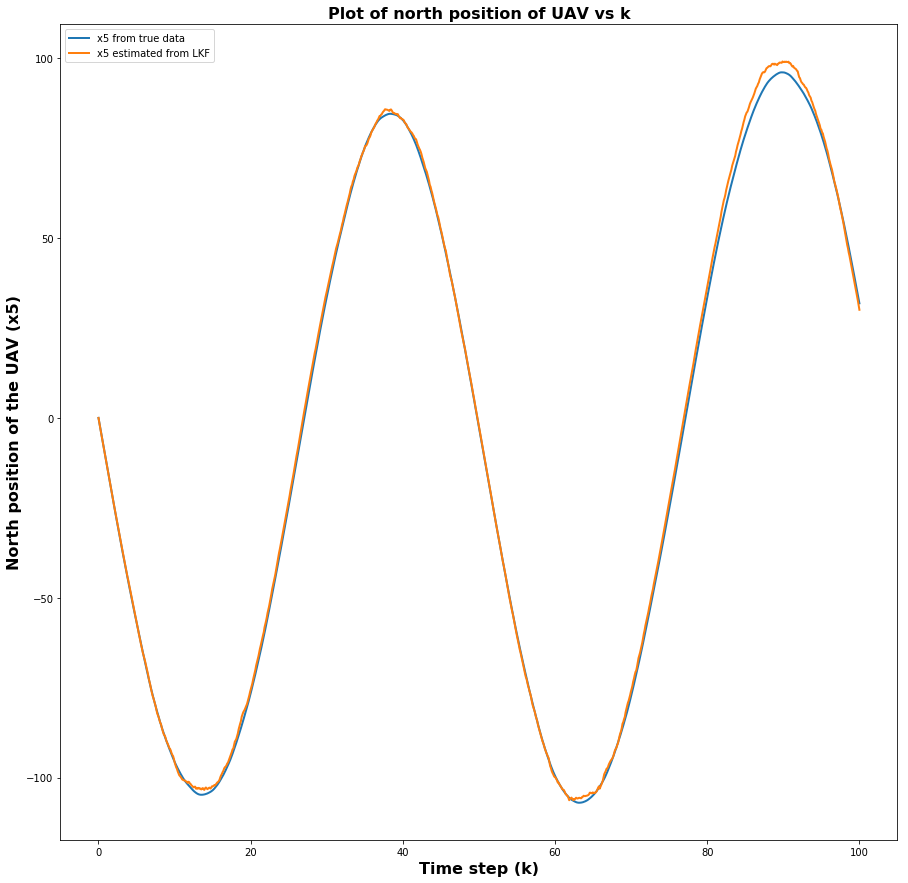

In [1499]:
#Plot x[5] or north position of UAV

true_x5 = []
estimated_x5 = []

for state in Xtrue:
    true_x5.append(state[4])
    
for state in estimated_state_list:
    estimated_x5.append(state[4][0])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("North position of the UAV (x5)",fontsize=16, fontweight='bold')
plt.title("Plot of north position of UAV vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,true_x5,linewidth = 2,label = 'x5 from true data')
plt.plot(time_steps,estimated_x5,linewidth = 2,label = 'x5 estimated from LKF')
plt.legend()



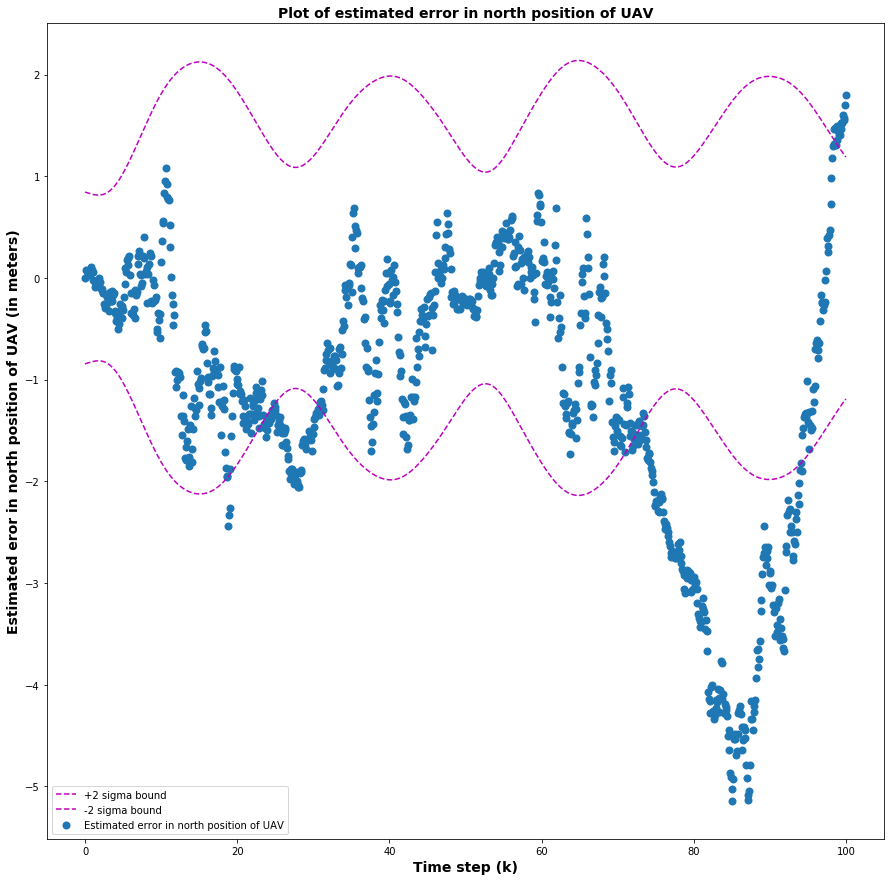

In [1500]:
#Error in north position of UAV
estimated_state5_error_list = []
positive_two_sigma_state_element5_list = []
negative_two_sigma_state_element5_list = []

for i in range(0,len(estimated_state_list)):
    curr_estimate = estimated_x5[i]
    curr_variance = estimated_covariance_matrix_list[i][4][4]
    sigma = np.sqrt(curr_variance)
    bound = 2*sigma
    curr_error = true_x5[i] - curr_estimate
    estimated_state5_error_list.append(curr_error)
    positive_two_sigma_state_element5_list.append(bound)
    negative_two_sigma_state_element5_list.append(-bound)
    
plt.xlabel("Time step (k)",fontsize=14, fontweight='bold')
plt.ylabel("Estimated eror in north position of UAV (in meters)",fontsize=14, fontweight='bold')
plt.title("Plot of estimated error in north position of UAV",fontsize=14, fontweight='bold')
plt.scatter(time_steps[skip_till:],estimated_state5_error_list[skip_till:],linewidth = 2,label = 'Estimated error in north position of UAV')
plt.plot(time_steps[skip_till:],positive_two_sigma_state_element5_list[skip_till:],'--m',label = '+2 sigma bound')
plt.plot(time_steps[skip_till:],negative_two_sigma_state_element5_list[skip_till:],'--m',label = '-2 sigma bound')
plt.legend()

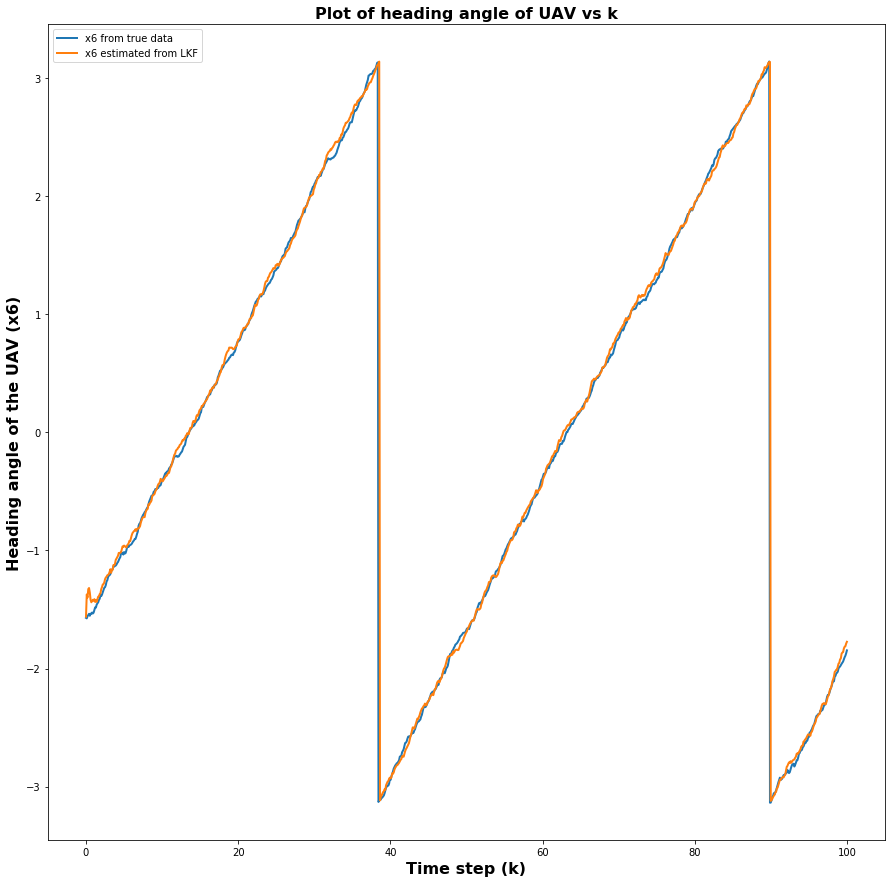

In [1501]:
#Plot x[6] or heading angle of UAV

true_x6 = []
estimated_x6 = []

for state in Xtrue:
    true_x6.append(state[5])
    
for state in estimated_state_list:
    estimated_x6.append(state[5][0])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("Heading angle of the UAV (x6)",fontsize=16, fontweight='bold')
plt.title("Plot of heading angle of UAV vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,true_x6,linewidth = 2,label = 'x6 from true data')
plt.plot(time_steps,estimated_x6,linewidth = 2,label = 'x6 estimated from LKF')
plt.legend()



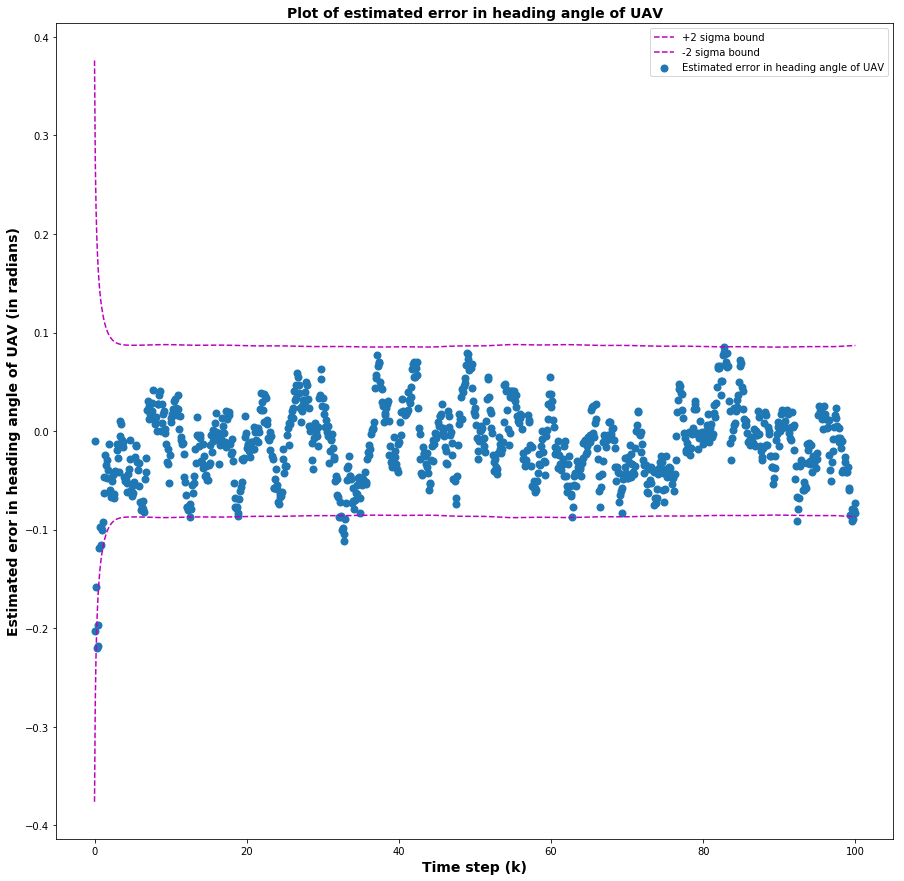

In [1502]:
#Error in heading angle of UAV
estimated_state6_error_list = []
positive_two_sigma_state_element6_list = []
negative_two_sigma_state_element6_list = []

for i in range(0,len(estimated_state_list)):
    curr_estimate = estimated_x6[i]
    curr_variance = estimated_covariance_matrix_list[i][5][5]
    sigma = np.sqrt(curr_variance)
    bound = 2*sigma
    curr_error = true_x6[i] - curr_estimate
    curr_error = wrap_in_negative_pi_to_pi(curr_error)
    estimated_state6_error_list.append(curr_error)
    positive_two_sigma_state_element6_list.append(bound)
    negative_two_sigma_state_element6_list.append(-bound)

plt.xlabel("Time step (k)",fontsize=14, fontweight='bold')
plt.ylabel("Estimated eror in heading angle of UAV (in radians)",fontsize=14, fontweight='bold')
plt.title("Plot of estimated error in heading angle of UAV",fontsize=14, fontweight='bold')
plt.scatter(time_steps[skip_till:],estimated_state6_error_list[skip_till:],linewidth = 2,label = 'Estimated error in heading angle of UAV')
plt.plot(time_steps[skip_till:],positive_two_sigma_state_element6_list[skip_till:],'--m',label = '+2 sigma bound')
plt.plot(time_steps[skip_till:],negative_two_sigma_state_element6_list[skip_till:],'--m',label = '-2 sigma bound')
plt.legend()

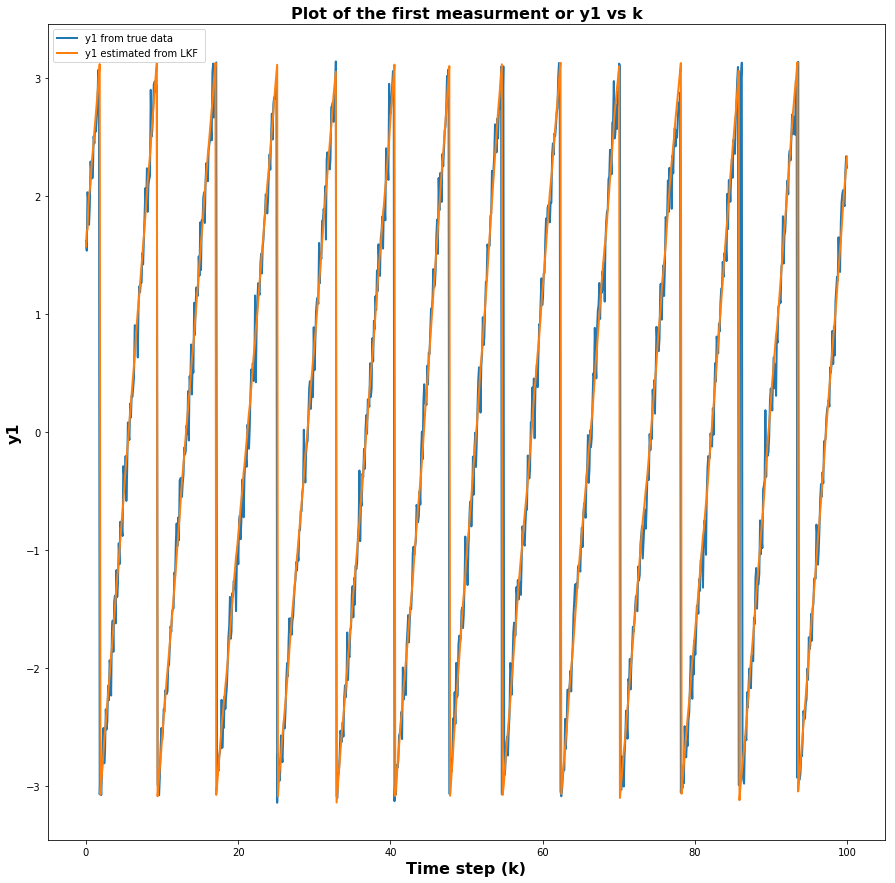

In [1503]:
#Plot y[1]

true_y1 = []
estimated_y1 = []

for state in Ytrue:
    true_y1.append(state[0])
    
for state in estimated_measurement_list:
    estimated_y1.append(state[0])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("y1",fontsize=16, fontweight='bold')
plt.title("Plot of the first measurment or y1 vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,true_y1,linewidth = 2,label = 'y1 from true data')
plt.plot(time_steps,estimated_y1,linewidth = 2,label = 'y1 estimated from LKF ')
plt.legend()

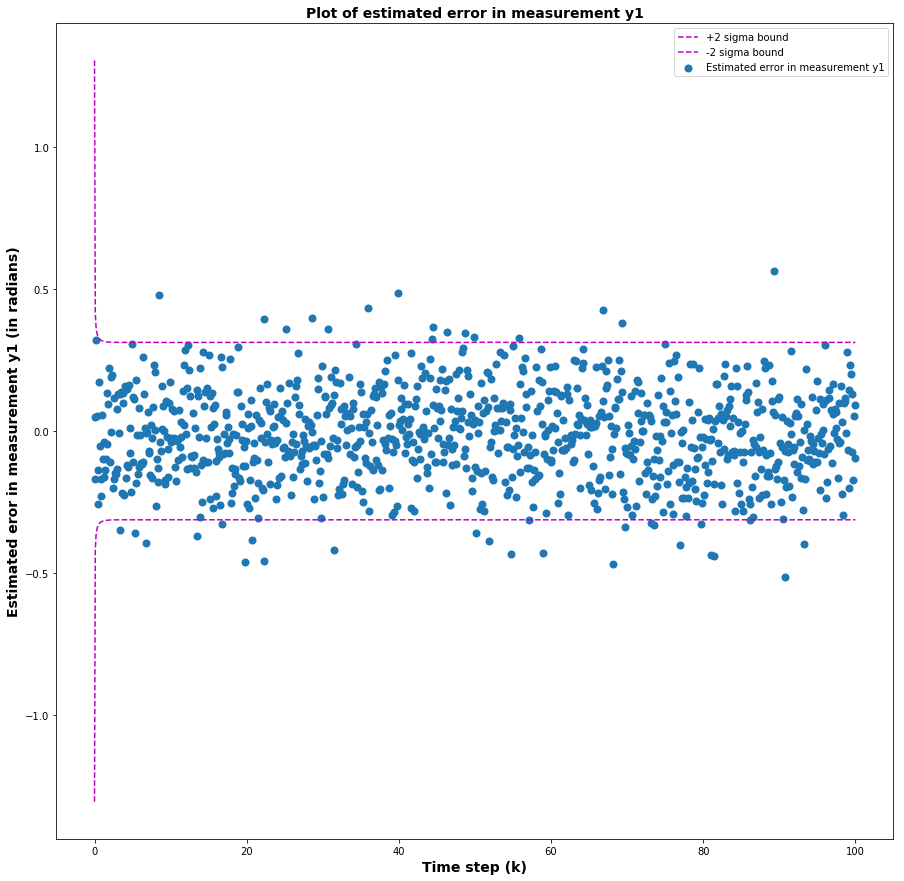

In [1504]:
skip_till = 0
#Error in y1
estimated_measurement1_error_list = []
positive_two_sigma_state_measurement1_list = []
negative_two_sigma_state_measurement1_list = []

for i in range(0,len(estimated_measurement_list)):
    curr_estimate = estimated_y1[i]
    curr_variance = innovation_covariance_matrix_list[i][0][0]
    sigma = np.sqrt(curr_variance)
    bound = 2*sigma
    curr_error = true_y1[i] - curr_estimate
    curr_error = wrap_in_negative_pi_to_pi(curr_error)
    estimated_measurement1_error_list.append(curr_error)
    positive_two_sigma_state_measurement1_list.append(bound)
    negative_two_sigma_state_measurement1_list.append(-bound)

plt.xlabel("Time step (k)",fontsize=14, fontweight='bold')
plt.ylabel("Estimated eror in measurement y1 (in radians)",fontsize=14, fontweight='bold')
plt.title("Plot of estimated error in measurement y1",fontsize=14, fontweight='bold')
plt.scatter(time_steps[skip_till:],estimated_measurement1_error_list[skip_till:],linewidth = 2,label = 'Estimated error in measurement y1')
plt.plot(time_steps[skip_till:],positive_two_sigma_state_measurement1_list[skip_till:],'--m',label = '+2 sigma bound')
plt.plot(time_steps[skip_till:],negative_two_sigma_state_measurement1_list[skip_till:],'--m',label = '-2 sigma bound')
plt.legend()

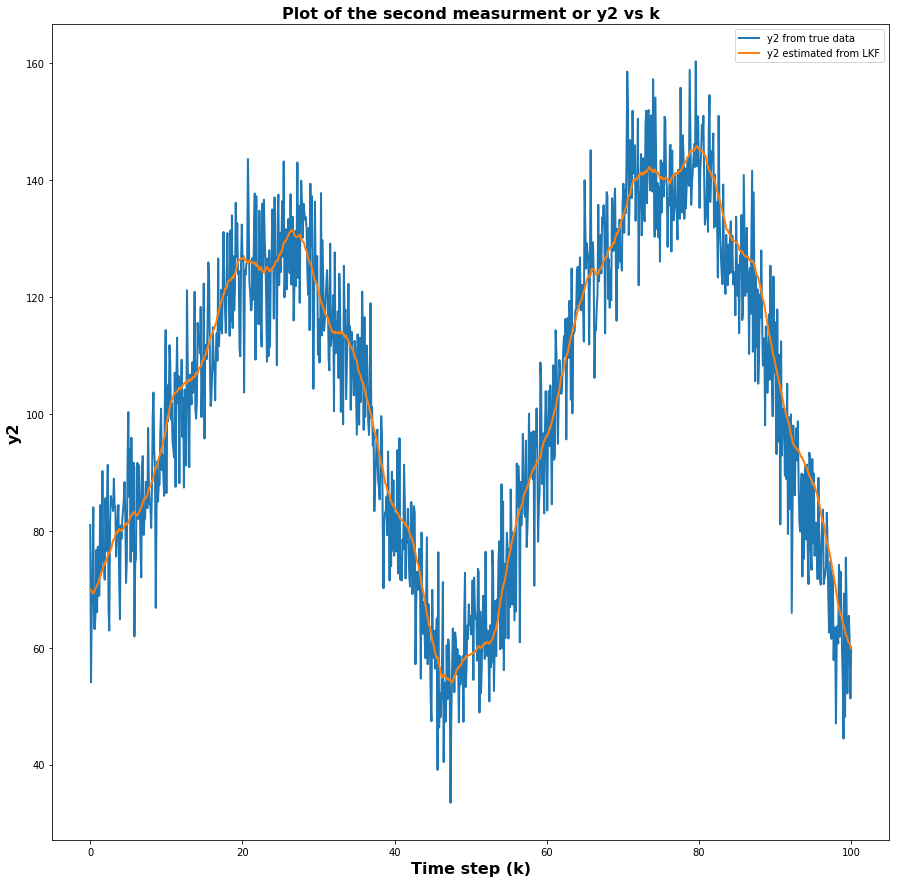

In [1505]:
#Plot y[2]

true_y2 = []
estimated_y2 = []

for state in Ytrue:
    true_y2.append(state[1])
    
for state in estimated_measurement_list:
    estimated_y2.append(state[1])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("y2",fontsize=16, fontweight='bold')
plt.title("Plot of the second measurment or y2 vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,true_y2,linewidth = 2,label = 'y2 from true data')
plt.plot(time_steps,estimated_y2,linewidth = 2,label = 'y2 estimated from LKF')
plt.legend()



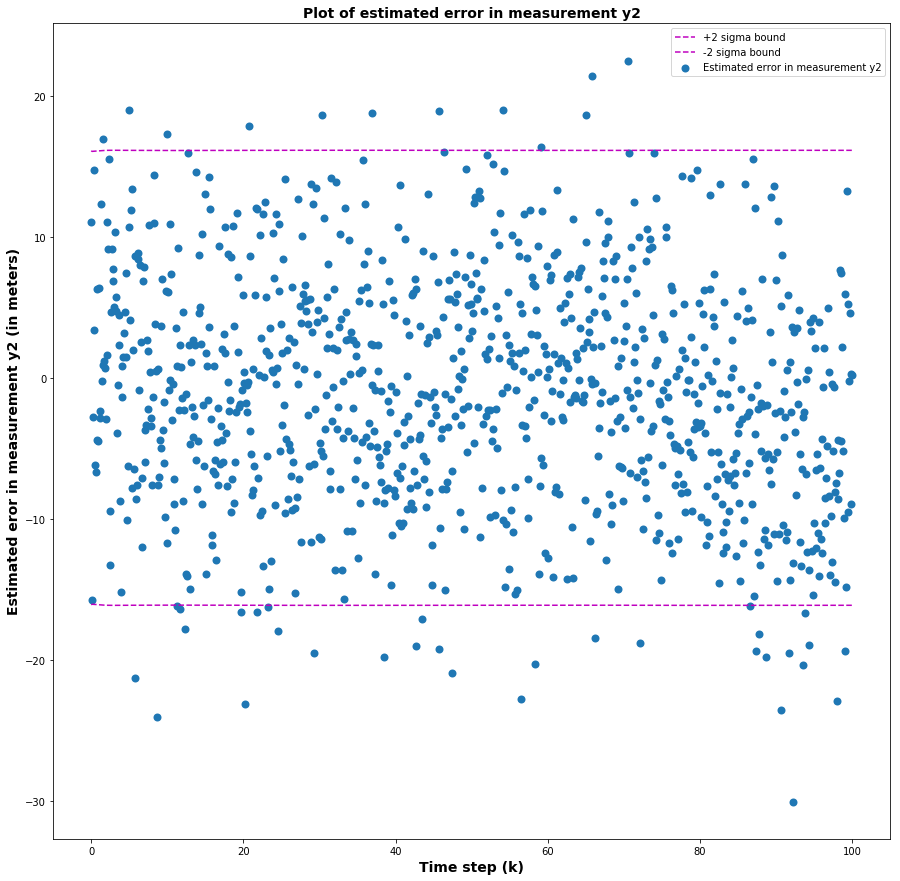

In [1506]:
#Error in y2
estimated_measurement2_error_list = []
positive_two_sigma_state_measurement2_list = []
negative_two_sigma_state_measurement2_list = []

for i in range(0,len(estimated_measurement_list)):
    curr_estimate = estimated_y2[i]
    curr_variance = innovation_covariance_matrix_list[i][1][1]
    sigma = np.sqrt(curr_variance)
    bound = 2*sigma
    curr_error = true_y2[i] - curr_estimate
    estimated_measurement2_error_list.append(curr_error)
    positive_two_sigma_state_measurement2_list.append(bound)
    negative_two_sigma_state_measurement2_list.append(-bound)

plt.xlabel("Time step (k)",fontsize=14, fontweight='bold')
plt.ylabel("Estimated eror in measurement y2 (in meters)",fontsize=14, fontweight='bold')
plt.title("Plot of estimated error in measurement y2",fontsize=14, fontweight='bold')
plt.scatter(time_steps[skip_till:],estimated_measurement2_error_list[skip_till:],linewidth = 2,label = 'Estimated error in measurement y2')
plt.plot(time_steps[skip_till:],positive_two_sigma_state_measurement2_list[skip_till:],'--m',label = '+2 sigma bound')
plt.plot(time_steps[skip_till:],negative_two_sigma_state_measurement2_list[skip_till:],'--m',label = '-2 sigma bound')
plt.legend()

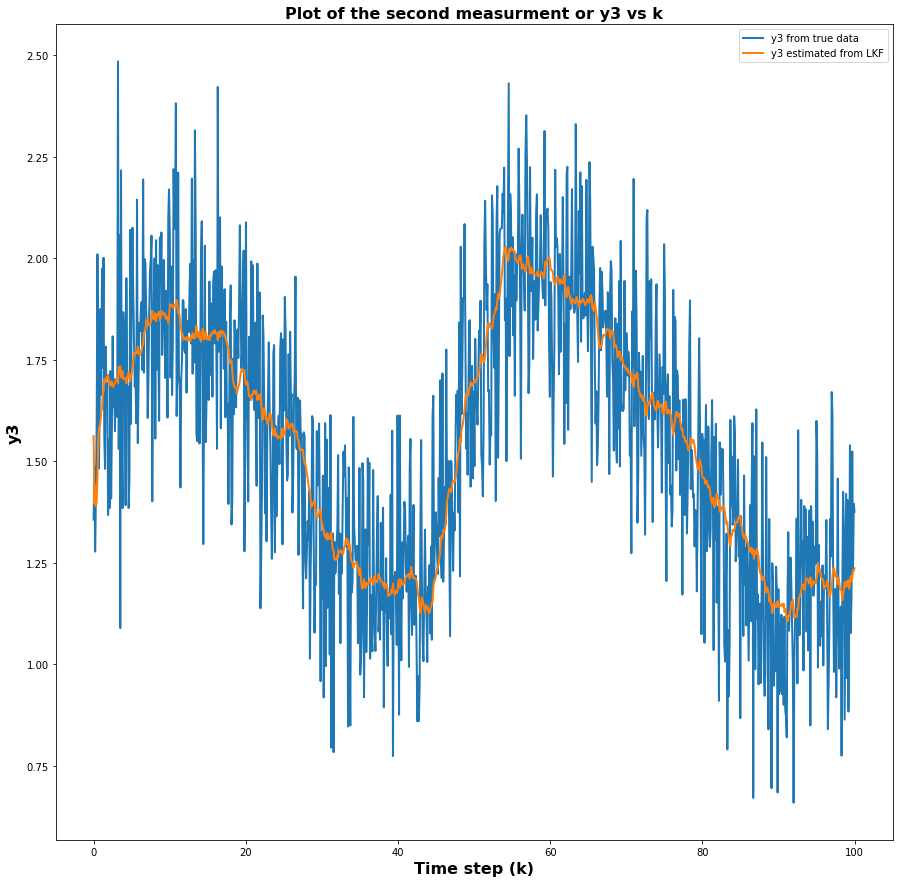

In [1507]:
#Plot y[3]

true_y3 = []
estimated_y3 = []

for state in Ytrue:
    true_y3.append(state[2])
    
for state in estimated_measurement_list:
    estimated_y3.append(state[2])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("y3",fontsize=16, fontweight='bold')
plt.title("Plot of the second measurment or y3 vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,true_y3,linewidth = 2,label = 'y3 from true data')
plt.plot(time_steps,estimated_y3,linewidth = 2,label = 'y3 estimated from LKF')
plt.legend()

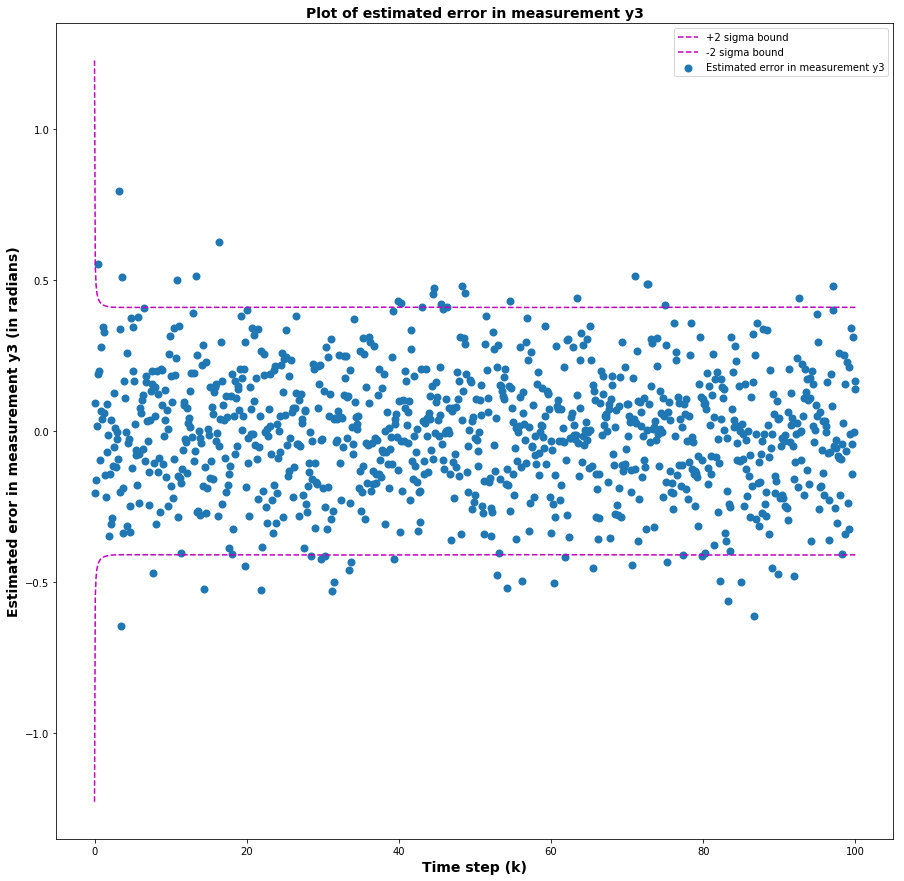

In [1508]:
#Error in y3
estimated_measurement3_error_list = []
positive_two_sigma_state_measurement3_list = []
negative_two_sigma_state_measurement3_list = []

for i in range(0,len(estimated_measurement_list)):
    curr_estimate = estimated_y3[i]
    curr_variance = innovation_covariance_matrix_list[i][2][2]
    sigma = np.sqrt(curr_variance)
    bound = 2*sigma
    curr_error = true_y3[i] - curr_estimate
    curr_error = wrap_in_negative_pi_to_pi(curr_error)    
    estimated_measurement3_error_list.append(curr_error)
    positive_two_sigma_state_measurement3_list.append(bound)
    negative_two_sigma_state_measurement3_list.append(-bound)

plt.xlabel("Time step (k)",fontsize=14, fontweight='bold')
plt.ylabel("Estimated eror in measurement y3 (in radians)",fontsize=14, fontweight='bold')
plt.title("Plot of estimated error in measurement y3",fontsize=14, fontweight='bold')
plt.scatter(time_steps[skip_till:],estimated_measurement3_error_list[skip_till:],linewidth = 2,label = 'Estimated error in measurement y3')
plt.plot(time_steps[skip_till:],positive_two_sigma_state_measurement3_list[skip_till:],'--m',label = '+2 sigma bound')
plt.plot(time_steps[skip_till:],negative_two_sigma_state_measurement3_list[skip_till:],'--m',label = '-2 sigma bound')
plt.legend()

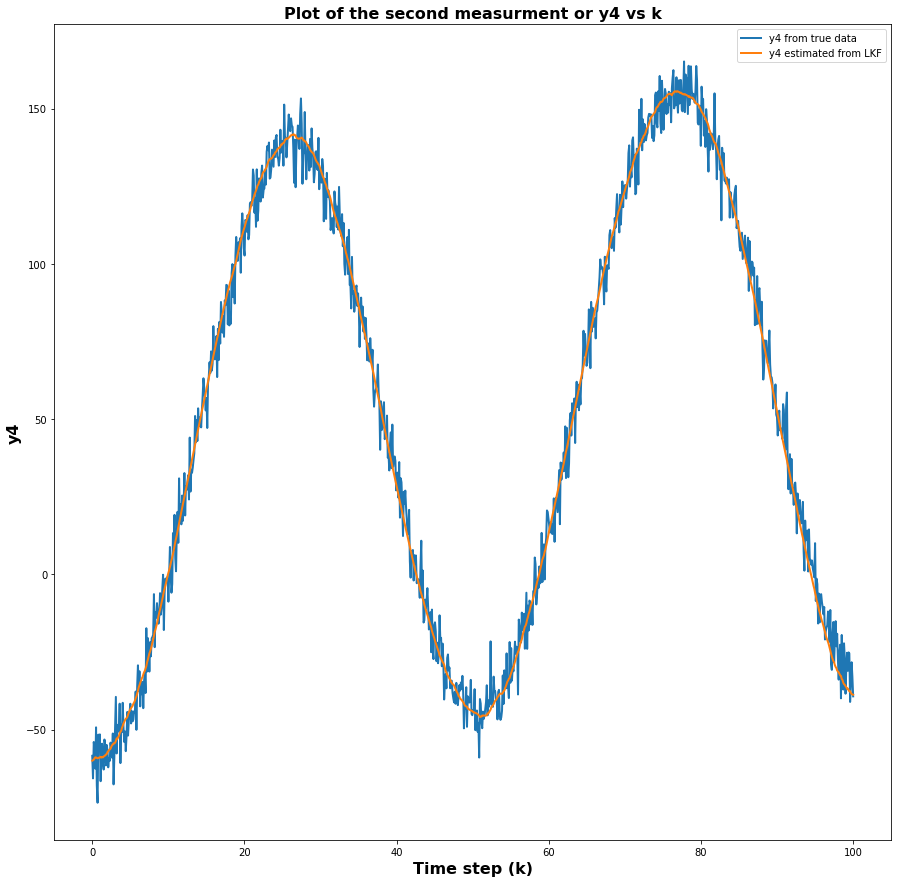

In [1509]:
#Plot y[4]

true_y4 = []
estimated_y4 = []

for state in Ytrue:
    true_y4.append(state[3])
    
for state in estimated_measurement_list:
    estimated_y4.append(state[3])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("y4",fontsize=16, fontweight='bold')
plt.title("Plot of the second measurment or y4 vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,true_y4,linewidth = 2,label = 'y4 from true data')
plt.plot(time_steps,estimated_y4,linewidth = 2,label = 'y4 estimated from LKF')
plt.legend()

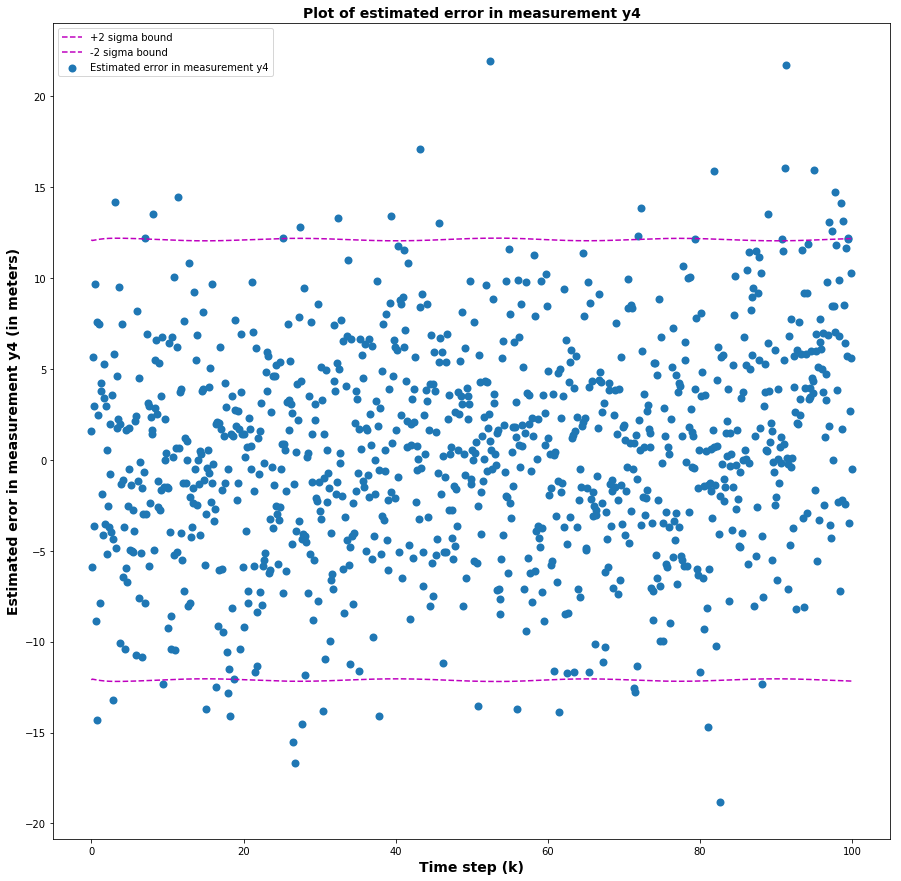

In [1510]:
#Error in y4
estimated_measurement4_error_list = []
positive_two_sigma_state_measurement4_list = []
negative_two_sigma_state_measurement4_list = []

for i in range(0,len(estimated_measurement_list)):
    curr_estimate = estimated_y4[i]
    curr_variance = innovation_covariance_matrix_list[i][3][3]
    sigma = np.sqrt(curr_variance)
    bound = 2*sigma
    curr_error = true_y4[i] - curr_estimate
    estimated_measurement4_error_list.append(curr_error)
    positive_two_sigma_state_measurement4_list.append(bound)
    negative_two_sigma_state_measurement4_list.append(-bound)

plt.xlabel("Time step (k)",fontsize=14, fontweight='bold')
plt.ylabel("Estimated eror in measurement y4 (in meters)",fontsize=14, fontweight='bold')
plt.title("Plot of estimated error in measurement y4",fontsize=14, fontweight='bold')
plt.scatter(time_steps[skip_till:],estimated_measurement4_error_list[skip_till:],linewidth = 2,label = 'Estimated error in measurement y4')
plt.plot(time_steps[skip_till:],positive_two_sigma_state_measurement4_list[skip_till:],'--m',label = '+2 sigma bound')
plt.plot(time_steps[skip_till:],negative_two_sigma_state_measurement4_list[skip_till:],'--m',label = '-2 sigma bound')
plt.legend()

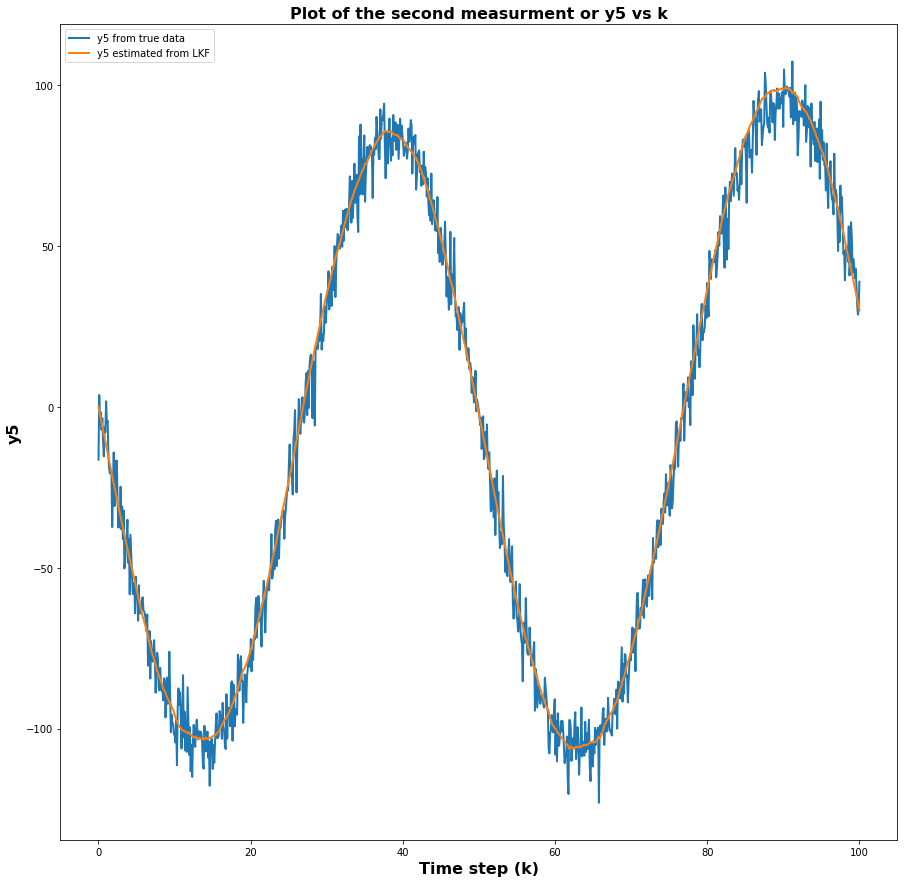

In [1511]:
#Plot y[5]

true_y5 = []
estimated_y5 = []

for state in Ytrue:
    true_y5.append(state[4])
    
for state in estimated_measurement_list:
    estimated_y5.append(state[4])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("y5",fontsize=16, fontweight='bold')
plt.title("Plot of the second measurment or y5 vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,true_y5,linewidth = 2,label = 'y5 from true data')
plt.plot(time_steps,estimated_y5,linewidth = 2,label = 'y5 estimated from LKF')
plt.legend()

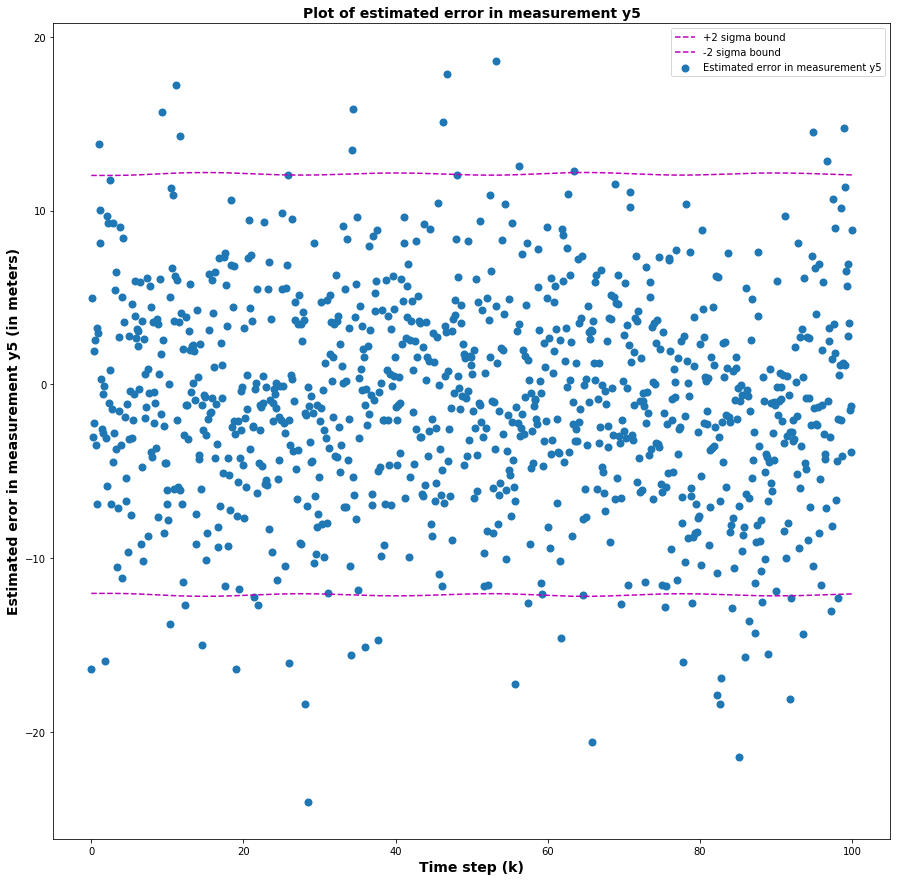

In [1512]:
#Error in y5
estimated_measurement5_error_list = []
positive_two_sigma_state_measurement5_list = []
negative_two_sigma_state_measurement5_list = []

for i in range(0,len(estimated_measurement_list)):
    curr_estimate = estimated_y5[i]
    curr_variance = innovation_covariance_matrix_list[i][4][4]
    sigma = np.sqrt(curr_variance)
    bound = 2*sigma
    curr_error = true_y5[i] - curr_estimate
    estimated_measurement5_error_list.append(curr_error)
    positive_two_sigma_state_measurement5_list.append(bound)
    negative_two_sigma_state_measurement5_list.append(-bound)

plt.xlabel("Time step (k)",fontsize=14, fontweight='bold')
plt.ylabel("Estimated eror in measurement y5 (in meters)",fontsize=14, fontweight='bold')
plt.title("Plot of estimated error in measurement y5",fontsize=14, fontweight='bold')
plt.scatter(time_steps[skip_till:],estimated_measurement5_error_list[skip_till:],linewidth = 2,label = 'Estimated error in measurement y5')
plt.plot(time_steps[skip_till:],positive_two_sigma_state_measurement5_list[skip_till:],'--m',label = '+2 sigma bound')
plt.plot(time_steps[skip_till:],negative_two_sigma_state_measurement5_list[skip_till:],'--m',label = '-2 sigma bound')
plt.legend()